In [1]:
# Amazon Fine Food Reviews Analysis
# Data : https://www.kaggle.com/snap/amazon-fine-food-reviews

In [29]:
# Load the data

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [30]:
# Reading the Data

con = sqlite3.connect("database.sqlite")

# Removing reviews > 3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con)

def partition(x):
    if x < 3:
        return 0
    return 1

actualScore = filtered_data["Score"]
positiveNegative = actualScore.map(partition)
filtered_data["Score"] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [31]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [32]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [33]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [34]:
display["COUNT(*)"].sum()

393063

In [35]:
# Exploratory Data Analysis
# Data Cleaning: Deduplication

display = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [36]:
filtered_data.shape

(5000, 10)

In [37]:
# Sorting data according to the ProductId
sorted_data = filtered_data.sort_values("ProductId", axis=0, ascending=True, inplace=False, kind="quicksort", na_position="last")

In [38]:
sorted_data.shape

(5000, 10)

In [39]:
# Deduplication of entries
final = sorted_data.drop_duplicates(subset={"UserId", "ProfileName", "Time", "Text"}, keep="first", inplace=False)
final.shape

(4986, 10)

In [40]:
# Checking to see how much % of data still remains
(final["Id"].size*1.0)/(filtered_data["Id"].size*1.0)*100

99.72

In [41]:
display = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [42]:
final = final[final["HelpfulnessNumerator"] <= final["HelpfulnessDenominator"]]

In [43]:
print(final.shape)

final["Score"].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

In [44]:
# Text Preprocessing
# 1. Remove HTML tags
# 2. Remove punctuation
# 3. Remove alpha-numeric
# 4. Word length > 2
# 5. Convert to lowercase
# 6. Remove stopwords
# 7. Snowball Stemming

In [45]:
# random reviews
sent_0 = final["Text"].values[0]
print(sent_0)
print("="*50)

sent_1000 = final["Text"].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final["Text"].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final["Text"].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [46]:
# remove URLs https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_1500 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [47]:
# remove tags
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element

from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, "lxml")
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, "lxml")
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, "lxml")
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, "lxml")
text = soup.get_text()
print(text)
print("="*50)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [48]:
# https://stackoverflow.com/a/47091490/4084039

def decontracted(phrase):
    
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [49]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [50]:
# remove words with numbers
# https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [51]:
# remove special chars
# https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub("[^A-Za-z0-9]", " ", sent_1500)
print(sent_1500)

Wow   So far  two two star reviews   One obviously had no idea what they were ordering  the other wants crispy cookies   Hey  I am sorry  but these reviews do nobody any good beyond reminding us to look  before ordering  br    br   These are chocolate oatmeal cookies   If you do not like that combination  do not order this type of cookie   I find the combo quite nice  really   The oatmeal sort of  calms  the rich chocolate flavor and gives the cookie sort of a coconut type consistency   Now let is also remember that tastes differ  so  I have given my opinion  br    br   Then  these are soft  chewy cookies    as advertised   They are not  crispy  cookies  or the blurb would say  crispy   rather than  chewy    I happen to like raw cookie dough  however  I do not see where these taste like raw cookie dough   Both are soft  however  so is this the confusion   And  yes  they stick together   Soft cookies tend to do that   They are not individually wrapped  which would add to the cost   Oh y

In [52]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [53]:
sent_1500

'Wow   So far  two two star reviews   One obviously had no idea what they were ordering  the other wants crispy cookies   Hey  I am sorry  but these reviews do nobody any good beyond reminding us to look  before ordering  br    br   These are chocolate oatmeal cookies   If you do not like that combination  do not order this type of cookie   I find the combo quite nice  really   The oatmeal sort of  calms  the rich chocolate flavor and gives the cookie sort of a coconut type consistency   Now let is also remember that tastes differ  so  I have given my opinion  br    br   Then  these are soft  chewy cookies    as advertised   They are not  crispy  cookies  or the blurb would say  crispy   rather than  chewy    I happen to like raw cookie dough  however  I do not see where these taste like raw cookie dough   Both are soft  however  so is this the confusion   And  yes  they stick together   Soft cookies tend to do that   They are not individually wrapped  which would add to the cost   Oh 

In [76]:
# Combining all the above statements
from tqdm import tqdm
preprocessed_reviews = []
review_score = []
# tqdm is for printing the status bar
for sentence, score in tqdm(final[["Text", "Score"]].values):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, "lxml").get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("S*\d\S*", "", sentence).strip()
    sentence = re.sub("[^A-Za-z]+", " ", sentence)
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentence.strip())
    review_score.append(score)

100%|██████████| 4986/4986 [00:01<00:00, 3922.77it/s]


In [77]:
final["Text"].values[1500]

'Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I\'m sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you don\'t like that combination, don\'t order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let\'s also remember that tastes differ; so, I\'ve given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I don\'t see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They aren\'t individually wrapped, which would add to the cost.  Oh y

In [78]:
preprocessed_reviews[1500]

'wow far two two star reviews one obviously no idea ordering wants crispy cookies hey sorry reviews nobody good beyond reminding us look ordering chocolate oatmeal cookies not like combination not order type cookie find combo quite nice really oatmeal sort calms rich chocolate flavor gives cookie sort coconut type consistency let also remember tastes differ given opinion soft chewy cookies advertised not crispy cookies blurb would say crispy rather chewy happen like raw cookie dough however not see taste like raw cookie dough soft however confusion yes stick together soft cookies tend not individually wrapped would add cost oh yeah chocolate chip cookies tend somewhat sweet want something hard crisp suggest nabiso ginger snaps want cookie soft chewy tastes like combination chocolate oatmeal give try place second order'

In [79]:
# sentence = final["Text"].values[1500]
# sentence = re.sub(r"http\S+", "", sentence)
# print(sentence) #1
# print("="*50)
# sentence = BeautifulSoup(sentence, "lxml").get_text()
# print(sentence) #2
# print("="*50)
# sentence = decontracted(sentence)
# print(sentence) #3
# print("="*50)
# sentence = re.sub("S*\d\S*", "", sentence).strip()
# print(sentence) #4
# print("="*50)
# sentence = re.sub("[^A-Za-z]+", " ", sentence)
# print(sentence) #5
# print("="*50)
# sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
# print(sentence.strip()) #6

In [80]:
# Same process for Summary
# Combining all the above statements
from tqdm import tqdm
preprocessed_summaries = []
# tqdm is for printing the status bar
for sentence in tqdm(final["Summary"].values):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, "lxml").get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("S*\d\S*", "", sentence).strip()
    sentence = re.sub("[^A-Za-z]+", " ", sentence)
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_summaries.append(sentence.strip())

100%|██████████| 4986/4986 [00:00<00:00, 5706.15it/s]


In [81]:
print(final["Summary"].values[1500])

Are We Reviewing Our Mistakes Or These Cookies?


In [82]:
preprocessed_summaries[1500]

'reviewing mistakes cookies'

In [83]:
# Featurization
# BoW (Bag of Words)

count_vect = CountVectorizer()
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print("="*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ", type(final_counts))
print("the shape of out text BOW vectorizer ", final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 13010)
the number of unique words  13010


In [84]:
# Bi-gram, tri-gram, n-gram
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ", type(final_bigram_counts))
print("the shape of out text BOW vectorizer", final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer (4986, 3147)
the number of unique words including both unigrams and bigrams  3147


In [85]:
# Tf-IDF
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)", tf_idf_vect.get_feature_names()[0:10])
print("="*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ", type(final_tf_idf))
print("the shape of out text TFIDF vectorizer", final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer (4986, 3147)
the number of unique words including both unigrams and bigrams  3147


In [86]:
# Train your own Word2Vec model using your own text corpus
i = 0
list_of_sentence = []
for sentence in preprocessed_reviews:
    list_of_sentence.append(sentence.split())

In [87]:
#list_of_sentence[1500]

In [88]:
is_your_ram_gt_16g = False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5, words that occured at least 5 times
    w2v_model = Word2Vec(list_of_sentence, min_count=5, size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print("="*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have google's word2vec file, keep want_to_train_w2v = True, to train your own w2v")

[('alternative', 0.9943246841430664), ('satisfying', 0.9941200017929077), ('tasty', 0.9936009645462036), ('snack', 0.9934931993484497), ('salty', 0.9934127926826477), ('amount', 0.9929834604263306), ('want', 0.9929012656211853), ('think', 0.9928248524665833), ('calorie', 0.9927350878715515), ('right', 0.9926907420158386)]
[('remember', 0.9993492960929871), ('english', 0.9993290305137634), ('experience', 0.9993245601654053), ('together', 0.9993205070495605), ('yes', 0.9993137121200562), ('gold', 0.9993041157722473), ('popcorn', 0.9992876052856445), ('de', 0.9992866516113281), ('takes', 0.9992557764053345), ('type', 0.999252200126648)]


In [89]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ", len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3819
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


In [90]:
# Converting text into vectors using wAvg W2V, Tf-Idf W2V

In [91]:
# Average Word2Vec
sent_vectors = []
for sent in tqdm(list_of_sentence):
    sent_vec = np.zeros(50)
    cnt_words = 0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 4986/4986 [00:03<00:00, 1522.16it/s]

4986
50


In [92]:
type(sent_vectors)

list

In [93]:
# Tfidf weighted W2V
model = TfidfVectorizer()
model.fit(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [94]:
tfidf_feat = model.get_feature_names()

tfidf_sent_vectors = []
row = 0
for sent in tqdm(list_of_sentence):
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word] * (sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 4986/4986 [00:16<00:00, 294.45it/s]


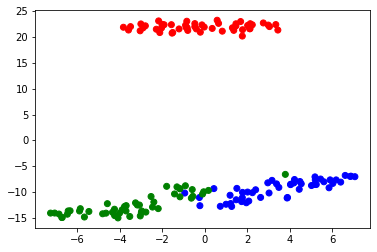

In [95]:
# Applying t-SNE
from openTSNE import TSNE
from sklearn import datasets

iris = datasets.load_iris()
x, y = iris["data"], iris["target"]

tsne = TSNE(n_components = 2, perplexity=30, learning_rate=200, n_jobs=4, initialization="pca",
            metric="euclidean", early_exaggeration_iter=250, early_exaggeration=12, n_iter=750)

X_embedding = tsne.fit(x)

for_tsne = np.hstack((X_embedding, y.reshape(-1, 1)))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=["Dimension_X", "Dimension_Y", "Score"])
colors = {0:"red", 1:"blue", 2:"green"}
plt.scatter(for_tsne_df["Dimension_X"], for_tsne_df["Dimension_Y"], c=for_tsne_df["Score"].apply(lambda x: colors[x]))
plt.show()

In [ ]:
# Applying TSNE on Text BOW vectors
perplexity_values = [2, 10]
iteration_values = [500, 1000]
print("2-D representation of BOW vectors using TSNE")

for perplexity in perplexity_values:
    for iteration in iteration_values:
        
        # converting the count vectors to sparse matrix form
        X, y = final_counts.A, review_score
        
        # setting up TSNE
        X_embedding = TSNE(n_components=2, random_state=42, perplexity=perplexity,
                           n_iter=iteration, n_jobs=5).fit(X)
        
        tsne_data = np.vstack((X_embedding.T, y)).T
        tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_X", "Dim_Y", "Score"))
        
        sns.set_style("whitegrid")
        sns.FacetGrid(tsne_df, hue="Score", height=8, palette=["r", "g"]).map(plt.scatter, "Dim_X", "Dim_Y").add_legend()
        plt.title("Using perplexity = {} Iterations = {}".format(perplexity, iteration))
        plt.show()

2-D representation of BOW vectors using TSNE
